In [2]:
import numpy as np
import scanpy as sc
import anndata
import pandas as pd
import matplotlib.pyplot as plt
import scipy

from cuml.decomposition import PCA
from cuml.manifold import TSNE

import warnings
warnings.filterwarnings('ignore', 'Expected ')

## Load data into scanpy

In [27]:
cellr = sc.read_10x_mtx("cellranger/filtered_feature_bc_matrix")
cellr.write("cellranger_filtered.sparse.h5ad")
cellr

... storing 'feature_types' as categorical


AnnData object with n_obs × n_vars = 7202 × 55633
    var: 'gene_ids', 'feature_types'

In [28]:
solo = sc.read_10x_mtx("/covid-omics/encode/Solo.out/Gene/filtered")
solo.write("solo_filtered.sparse.h5ad")
solo

... storing 'feature_types' as categorical


AnnData object with n_obs × n_vars = 6287 × 55633
    var: 'gene_ids', 'feature_types'

## Basic checks

### Check that genes are the same

In [29]:
all(cellr.var_names==solo.var_names)

True

### Cells are not the same!

In [30]:
print(cellr.obs.head())
print(solo.obs.head())

Empty DataFrame
Columns: []
Index: [AAACCTGAGAGTCGGT-1, AAACCTGAGTCGTACT-1, AAACCTGAGTGGTCCC-1, AAACCTGCAATGGACG-1, AAACCTGCACAGTCGC-1]
Empty DataFrame
Columns: []
Index: [AAACCTGAGTCGTACT, AAACCTGAGTGGTCCC, AAACCTGCAATGGACG, AAACCTGCAGCTGTTA, AAACCTGCAGTCAGCC]


### Fix cellranger IDs

In [31]:
cellr.obs=pd.DataFrame(index=pd.Index([x[:16] for x in list(cellr.obs.index)]))

## Drop spike-ins

In [32]:
cellr = cellr[:, np.invert(cellr.var_names.str.startswith("gSpike"))]
cellr

View of AnnData object with n_obs × n_vars = 7202 × 55536
    var: 'gene_ids', 'feature_types'

In [33]:
solo = solo[:, np.invert(solo.var_names.str.startswith("gSpike"))]
solo

View of AnnData object with n_obs × n_vars = 6287 × 55536
    var: 'gene_ids', 'feature_types'

## Basic QC

In [34]:
# Label mitochondrial genes
cellr.var['mt'] = cellr.var_names.str.startswith('mt-')
solo.var['mt'] = solo.var_names.str.startswith('mt-')

Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.


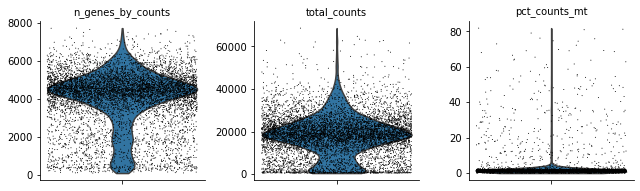

In [35]:
sc.pp.calculate_qc_metrics(cellr, qc_vars=['mt'], percent_top=None, inplace=True)
sc.pl.violin(cellr, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)

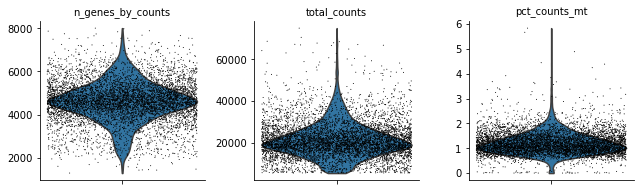

In [36]:
sc.pp.calculate_qc_metrics(solo, qc_vars=['mt'], percent_top=None, inplace=True)
sc.pl.violin(solo, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)

## Cellranger filters more cells (7202 vs. 6287). What's different?

### How many cells are common/different?

In [37]:
common_barcodes = set(cellr.obs.index).intersection(set(solo.obs.index))
len(common_barcodes)

6287

### Split counts by common vs different cells

In [38]:
barcode_is_common = [x in common_barcodes for x in cellr.obs.index]
cellr_common = cellr[barcode_is_common,:]
print(cellr_common)
cellr_diff = cellr[np.invert(barcode_is_common),:]
print(cellr_diff)

View of AnnData object with n_obs × n_vars = 6287 × 55536
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
View of AnnData object with n_obs × n_vars = 915 × 55536
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'


### View QC metrics for common vs. unique cells

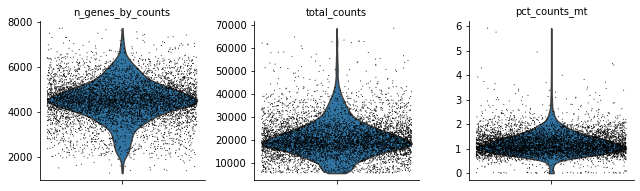

In [39]:
sc.pl.violin(cellr_common, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)

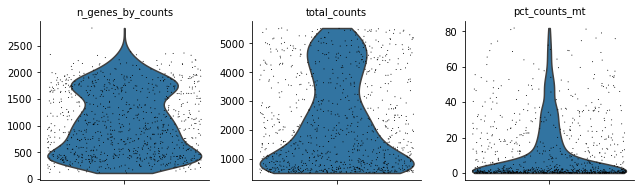

In [40]:
sc.pl.violin(cellr_diff, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)

## Correlation between count matrices

In [41]:
cmat=np.array(cellr_common.X.todense())
smat=np.array(solo.X.todense())

### Correlation between total counts per cell

In [25]:
np.corrcoef(cmat.sum(axis=1), smat.sum(axis=1))

array([[1.        , 0.99979462],
       [0.99979462, 1.        ]])

### Correlations between per-gene counts

In [45]:
cors=[]
for i in range(55536):
    cors.append(np.corrcoef(cmat[:,i], smat[:,i])[0,1])
cors = np.array(cors)[~np.isnan(cors)]

In [46]:
len(cors)
print(np.mean(cors))
print(np.median(cors))

0.9599149111011012
0.9878145794966152


(array([1.0000e+00, 2.0000e+00, 1.0000e+00, 4.0000e+00, 7.0000e+00,
        6.0000e+00, 5.0000e+00, 6.0000e+00, 1.0000e+01, 1.2000e+01,
        9.0000e+00, 2.7000e+01, 1.7000e+01, 4.5000e+01, 4.3000e+01,
        7.4000e+01, 4.9000e+01, 5.2000e+01, 9.8000e+01, 6.5000e+01,
        7.3000e+01, 4.8000e+01, 4.1000e+01, 1.4300e+02, 5.1000e+01,
        5.2000e+01, 4.1000e+01, 6.1000e+01, 3.5000e+01, 3.7000e+01,
        2.3000e+01, 2.8600e+02, 2.0000e+01, 2.3000e+01, 3.5000e+01,
        4.2000e+01, 2.8000e+01, 1.9000e+01, 1.4700e+02, 2.4000e+01,
        3.8000e+01, 1.1900e+02, 4.1000e+01, 9.9000e+01, 1.1000e+02,
        1.9500e+02, 2.6000e+02, 5.6000e+02, 3.8770e+03, 1.7772e+04]),
 array([0.19961783, 0.21562548, 0.23163312, 0.24764076, 0.26364841,
        0.27965605, 0.29566369, 0.31167134, 0.32767898, 0.34368662,
        0.35969427, 0.37570191, 0.39170955, 0.4077172 , 0.42372484,
        0.43973248, 0.45574013, 0.47174777, 0.48775541, 0.50376306,
        0.5197707 , 0.53577834, 0.55178599, 0.

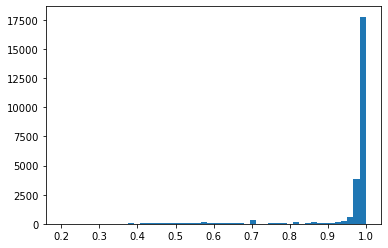

In [47]:
plt.hist(cors, bins=50)

## Filter out genes with zero expression in all cells

In [48]:
sc.pp.filter_genes(cellr, min_cells=1)
cellr

AnnData object with n_obs × n_vars = 7202 × 24890
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'

In [49]:
sc.pp.filter_genes(solo, min_cells=1)
solo

AnnData object with n_obs × n_vars = 6287 × 25426
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'

## Preprocess count matrices

In [50]:
# Normalize
sc.pp.normalize_total(cellr, target_sum=1e4)
sc.pp.log1p(cellr)

# Filter variable genes
sc.pp.highly_variable_genes(cellr, n_top_genes=5000, flavor="cell_ranger")
cellr = cellr[:, cellr.var.highly_variable]
sc.pp.scale(cellr, max_value=10)

In [51]:
sc.pp.normalize_total(solo, target_sum=1e4)
sc.pp.log1p(solo)

sc.pp.highly_variable_genes(solo, n_top_genes=5000, flavor="cell_ranger")
solo = solo[:, solo.var.highly_variable]
sc.pp.scale(solo, max_value=10)

/raj-test/rapidgenomics-5/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:848: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/raj-test/rapidgenomics-5/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:848: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


## Dimension reduction

In [52]:
# PCA
cellr.obsm["X_pca"] = PCA(n_components=50).fit_transform(cellr.X)
# UMAP
sc.pp.neighbors(cellr, n_neighbors=20, n_pcs=50, method='rapids')
sc.tl.umap(cellr, spread=1, min_dist=0.6, method='rapids')

In [53]:
# PCA
solo.obsm["X_pca"] = PCA(n_components=50).fit_transform(solo.X)
# UMAP
sc.pp.neighbors(solo, n_neighbors=20, n_pcs=50, method='rapids')
sc.tl.umap(solo, spread=1, min_dist=0.6, method='rapids')

## Clustering

### Louvain

/raj-test/rapidgenomics-5/lib/python3.7/site-packages/cugraph/structure/graph.py:329: UserWarning: add_adj_list will be deprecated in next release. Use from_cudf_adjlist instead
  Use from_cudf_adjlist instead')


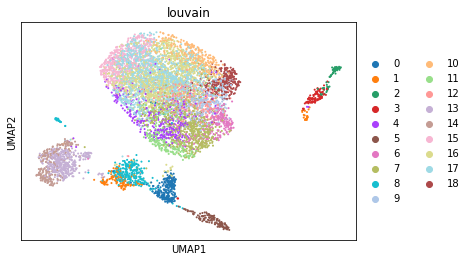

In [54]:
sc.tl.louvain(cellr, flavor='rapids')
sc.pl.umap(cellr, color=["louvain"])

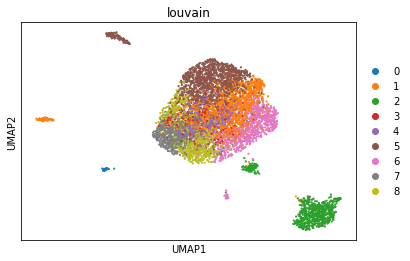

In [55]:
sc.tl.louvain(solo, flavor='rapids')
sc.pl.umap(solo, color=["louvain"])

### Leiden

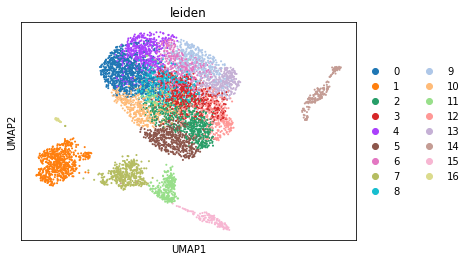

In [57]:
sc.tl.leiden(cellr)
sc.pl.umap(cellr, color=["leiden"])

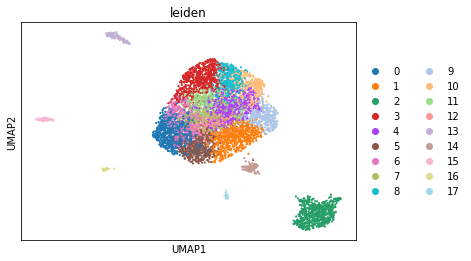

In [58]:
sc.tl.leiden(solo)
sc.pl.umap(solo, color=["leiden"])

## Compare cluster assignments from Cellranger and STARsolo

In [59]:
c_common_leiden = np.array(cellr.obs['leiden'])[barcode_is_common]

In [61]:
import sklearn
sklearn.metrics.adjusted_rand_score(c_common_leiden, list(solo.obs['leiden']))

0.5978782054298323